# Understanding run_check_nr

In [ ]:
#	4a. Removing overlapping genes from taining set 
##################################################################
if [ ! -s $DELETE ]
then
	echo "No overlapping genes to remove"
	cp best_genes/makerRNAs.filtered.gff best_genes/makerRNAs.filtered.nolaps.gff
	date +"%d-%b-%y %T"
else
	echo "Removing overlapping genes from training set"
	grep -w -v -f $DELETE best_genes/makerRNAs.filtered.gff > best_genes/makerRNAs.filtered.nolaps.gff  
	date +"%d-%b-%y %T"
fi

echo "Tidying up"
mv overlapping* best_genes
date +"%d-%b-%y %T"

This will delete the genes found to be overlapping from previous script.makerRNAs.filtered.nolaps.gff is the gff output with overlapping genes removed.

In [ ]:
#	4b. Combining gff and fasta into genbank format 
##################################################################
echo "Creating genbank file:"
GB="${GENOME}_${COUNTIGS}.gb"
echo $GB

PROG="/home/data/bioinf_resources/programming_tools/busco-master/augustus-3.3.1/scripts/gff2gbSmallDNA.pl"
MAXSIZEOFFLANKINGDNA="4000"
$PROG best_genes/makerRNAs.filtered.nolaps.gff $ASSY $MAXSIZEOFFLANKINGDNA $GB
date +"%d-%b-%y %T"

The maximum-size of flanking DNA seems to be from a working example so was kept.
The perl script gff2gbSmallDNA.pl takes the input (genomic assembly + gff output from check_ol without overlapping genes and bad gene models) and gives the output of a feature table as a genebank file.

The genomic assembly should be okay instead of chromosome 1 since the program would only match what's in the gff with whatever chromosome.

In [ ]:
gff2gbSmallDNA.pl -h
Unknown option

/home/apps/scripts/gff2gbSmallDNA.pl -- convert GFF file and sequence fasta file to minimal genbank format

Usage: /home/apps/scripts/gff2gbSmallDNA.pl gff-file seq-file max-size-of-gene-flanking-DNA output-file [options]
options:
--bad=badfile    Specify a file with gene names. All except these are included in the output.
--good=goodfile  Specify a file with gene names. Only these genes are included in the output.
--overlap        Overlap filtering turned off.


In [ ]:
#	4c. Investigating training set for non-redundant proteins 
##################################################################

echo "Finding redundant genes in training geneset"
PROG="/home/data/bioinf_resources/programming_tools/EMBOSS-6.6.0/emboss/coderet"
echo "Extracting coding sequences"

COD=${GB/gb/fna}
PRO=${GB/gb/faa}

$PROG -seqall $GB -outfile temporary.log -cdsoutseq temporary.fna \
		-mrnaoutseq temporary.mrna -translationoutseq temporary.tr -restoutseq temporary.nc 2>&1

#	TODO retrieve correct headers from $GB
#	For now, just make headers different 
awk '/>/{sub(/1/,++i)}1' temporary.fna > $COD
rm temporary.*
echo "Translating coding sequences"
transeq -sequence $COD -outseq $PRO 2>&1
date +"%d-%b-%y %T"

echo "Running calc_pc_id_between_seqs to calculate the % identity between each pair of protein sequences"
##http://avrilomics.blogspot.com/2013/04/training-augustus-gene-finding-software.html
mkdir test_nonred
PATHTOGGSEARCH="/home/apps/rothhpc1-cluster/src/fasta-35.4.12/bin/ggsearch35"
PROG="/home/data/pest_genomics/scripts/dh/calc_pc_id_between_seqs.pl"
$PROG $PRO pc_out ./test_nonred $PATHTOGGSEARCH 2>&1
##Output:	test_nonred/pc_out
date +"%d-%b-%y %T"

sort test_nonred/pc_out -k3,3 -rn >test_nonred/pc_out.sorted
echo "Top protein pairs sorted by % identity are:"
head test_nonred/pc_out.sorted
echo "Hopefully none exceed 70%"
date +"%d-%b-%y %T"


Coderet manual http://www.bioinformatics.nl/cgi-bin/emboss/help/coderet

Calc_pc manual http://avrilomics.blogspot.com/2013/04/training-augustus-gene-finding-software.html

The genebank file is a feature table with CDS, mRNA and translation information etc. This is the input coderet needs to extract those information.

Calc_pc would then check for redundancy by calculating the percent identity between protein sequences using ggsearch. The %identity should be exceeding 70%.

### check_nr is running and scanning for protein redundancy

# Next steps

### Preparing RepeatMasking library

 - Repeatmasking library masks sections of genome corresponding to its content from being annotated.
 - Use blastn with parameter file decypher/parameter_files/modified/tera-blastn-tab and ncbi database to search for alignments in RepeatMasking library.
 - For hits use Rob's email's transposons_text.txt to extract transposons from the library.
 - Use the list of transposons found to ensure RepeatMasker library contains no genes, otherwise the genes would be masked.

### Curated proteins

Have a chat with Rob at some point to download curated proteins of fusarium for maker. 

### Maker re-run

2 runs

 - standard Maker on whole genome
 - Maker with evidence-transfer.

the latest ncbi nucleotide library

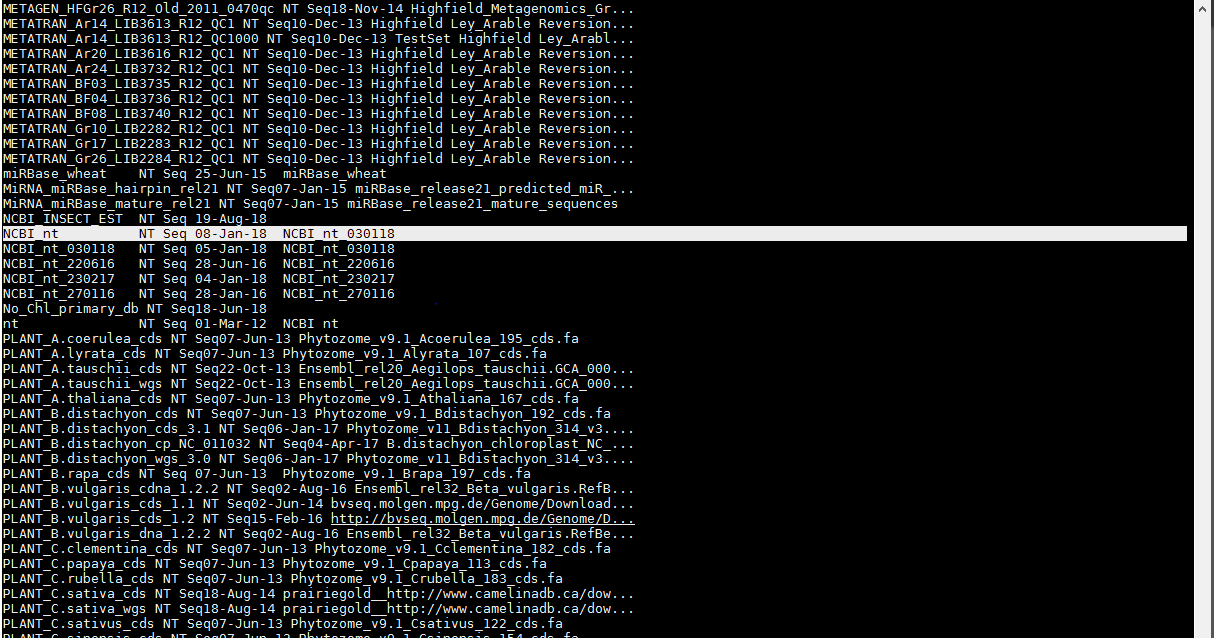

The update to the NCBI nt database is in 3 steps found in /bioinf_resources/decypher/bioinf_scripts/maintenance/